<h1>Sampling at equilibrium with the Langevin dynamics</h1>

<a id='langevin'></a>
<h2>The Langevin dynamics</h2>

We consider the following stochastic differential equations:
$$
\tag{Langevin}
\left\lbrace
\begin{aligned}
{\rm d}q_t &= \textcolor{blue}{M^{-1}p_t\,{\rm d}t},\\
{\rm d}p_t &= \textcolor{blue}{-\nabla V(q_t)\,{\rm d}t}\textcolor{red}{-\gamma M^{-1}p_t\,{\rm d}t+\sqrt{\frac{2\gamma}{\beta}}{\rm d}W_t},
\end{aligned}
\right.
$$
The $\textcolor{blue}{\rm blue}$ part are the Hamilton's equations of motion, the $\textcolor{red}{\rm red}$ part is an Ornstein-Uhlenbeck (OU) process. The OU process is an example of a thermostat (infinite reservoir of energy) that models the heat exchanges between the system and its environment (<i>e.g.</i> through collisions).

We denote by $d$ the dimension, and $N$ the number of particles composing the system at hand:
* $(q_t,p_t)\in\mathbb{R}^{dN\times dN}$ denotes the state of the system at time $t$, $q_t$ being the positions of the particles and $p_t$ their momenta;
* $t\mapsto W_t$ is a $dN$-dimensional standard Brownian motion;
* the total energy of a configuration $(q,p)$ is given by its Hamiltonian:
$$
H(q,p)=V(q)+\frac{1}{2}p^{\mathsf{T}}M^{-1}p,
$$
where $M={\rm diag}([m_i]_d)_{1\leqslant i\leqslant N}\in\mathcal{M}_{dN}(\mathbb{R})$ the mass matrix ($m_i$ is the mass of the $i$-th particle, appearing $d$ times in a row in the diagonal of $M$) and $V:\mathbb{R}^{dN}\to\mathbb{R}$ is the potential energy function modeling the interactions within the system.

Under standard assumptions, the process $(q_t,p_t)_{t\geqslant0}$ admits a unique equilibrium distribution, which is the Boltzmann-Gibbs probability distribution:
$$
\mu({\rm d}q\,{\rm d}p)=Z_\mu^{-1}{\rm e}^{-\beta H(q,p)}{\rm d}q\,{\rm d}p,\qquad Z_\mu=\int_{\mathbb{R}^{dN}\times\mathbb{R}^{dN}}{\rm e}^{-\beta H}.
$$

In this notebook, we consider $d=2$ and $N=1$. The goal is to compute a thermodynamic coefficient in this scenario, namely a quantity of the form
$$\int_{\mathbb{R}^2\times\mathbb{R}^2}f(q,p)\,\mu(\mathrm{d}q\,\mathrm{d}p),$$
with $f:\mathbb{R}^2\times\mathbb{R}^2\mapsto\mathbb{R}$ an observable. To ease the presentation, we will consider below an observable that only depends on the positions. In view of the form of the Boltzmann-Gibbs distribution, what really matters is then an approximation of
$$\tag{$\star$}\int_{\mathbb{R}^2}f(q)\,\pi(\mathrm{d}q),\qquad \pi(\mathrm{d}q)=Z_\pi^{-1}\mathrm{e}^{-\beta V(q)},\qquad Z_\pi=\int_{\mathbb{R}^2}\mathrm{e}^{-\beta V}.$$
$\pi$ is the marginal in position of $\mu$, and will also be referred here as the Boltzmann-Gibbs distribution. We will see how the Langevin dynamics can be used to build accurate approximations of $(\star)$ and analyze its accuracy for two potential energy functions.

In [49]:
# Installing all the imports. If needed, uncomment.
#using Pkg
#Pkg.add(["PyPlot", "LaTeXStrings", "Cubature", "StatsBase", "Polynomials"])
# First time compiling the PyPlot library takes a bit of time
using PyPlot, LaTeXStrings, Cubature, StatsBase, Polynomials

If you need any documentation here are comments/tips and documentation links:
* [PyPlot](https://github.com/JuliaPy/PyPlot.jl): Julia interface to the `matplotlib` library in Python. Function calls work like in the `matplotlib.pyplot` library, which documentation can be found [here](https://matplotlib.org/2.0.2/api/pyplot_api.html).
* [LaTeXStrings](https://github.com/JuliaStrings/LaTeXStrings.jl): Easier way to input strings that can be rendered using MathJax. Simply add `L` to the left of strings, and surround maths elements by `$`.
* [Cubature](https://github.com/JuliaMath/Cubature.jl): Estimation of (possibly multidimensional) integrals using quadrature methods.
* [StatsBase](https://github.com/JuliaStats/StatsBase.jl): Basic statistics support for Julia, which documentation can be found [here](https://juliastats.org/StatsBase.jl/stable/). 
* [Polynomials](https://github.com/JuliaMath/Polynomials.jl): Basic construction, evaluation, integration, differentiation, root-finding algorithms, data-fitting algorithms for univariate polynomials, which documentation can be found [here](https://juliamath.github.io/Polynomials.jl/stable/).

<h2>A first simple system</h2>

We consider a system composed of $N=1$ particle of mass 1 in dimension $d=2$, under the influence of a potential energy function $V$ which writes
$$
V(q)\equiv V(x,y)=(x^2+y^2)^2.
$$
The potential energy surface (PES) is only composed of one well (the energy function is in fact convex), Langevin dynamics should therefore be able to build very accurate estimators of thermodynamic coefficients.

<i>Julia particularities</i>
* `...` is the "splat" operator, which unpacks an Array/Tuple/Dict, equivalent to `*` and `**` in Python for example.
* `'` denotes the adjoint operator. For instance, it transposes an array.
* In Julia, one can define several functions with the same name and different arguments. In this context we will define functions on 1 particles, like `V(x, y)` for instance, and an array of particles with `V(q)`. 

In [50]:
# Definitions of the potential and its gradient

"""
    V(x, y)

Potential energy function.
"""
function V(x, y)
    return (x^2+y^2)^2
end

function V(q::Vector{<:Real})
    return V(q...)
end

"""
    ∇V(x, y)

Gradient of the potential energy function.
"""
function ∇V(x, y)

    return 4 * (x^2+y^2) * [x, y]
end

function ∇V(q::Vector{<:Real})
    return ∇V(q...)
end
;

In [51]:
# Define the Hamiltonian. Note that the mass is 1.

"""
    hamiltonian(q::Vector{<:Real},p::Vector{<:Real},V::Function)

Compute the Hamiltonian of the system H(q,p)=V(q)+|p|²/2.
"""
function hamiltonian(q::Vector{<:Real},p::Vector{<:Real},V::Function)
    return V(q) + p'*p/2
end
;

<a id='boltzmanngibbs'></a>
We define the Boltzmann-Gibbs distribution, using a quadrature method to compute the normalization constant/partition function.

In [52]:
# Define the Boltzmann-Gibbs distribution

β = 1. # Inverse temperature

"""
    boltzmann_gibbs_unnormalized(x,y,V::Function)

Compute the un-normalized Gibbs distribution.
"""
function boltzmann_gibbs_unnormalized(x,y,V::Function)
    return exp(-β*V(x,y))
end

function boltzmann_gibbs_unnormalized(q::Vector{<:Real}, V::Function)
    return boltzmann_gibbs_unnormalized(q..., V)
end

# Using a quadrature method to obtain the partition function
Zπ, err = hcubature(q->boltzmann_gibbs_unnormalized(q, V), (-10,-10),(10,10))
println("Value of ∫exp(-βV)dπ using a quadrature method is $(Zπ) ± $(err)")

"""
    boltzmann_gibbs(x,y, V::Function)

Compute the normalized Gibbs distribution.
"""
function boltzmann_gibbs(x,y, V::Function)
    return boltzmann_gibbs_unnormalized(x,y, V)/Zπ
end

function boltzmann_gibbs(q::Vector{<:Real}, V::Function)
    return boltzmann_gibbs(q..., V)
end
;

Value of ∫exp(-βV)dπ using a quadrature method is 2.7841639976781343 ± 2.7840876114522254e-8


In [53]:
# Define the equilibrium distribution in momenta. It will be useful for sanity checks.

"""
    standard_gaussian(x)

Compute the pdf of the unidimensional Gaussian distribution of mean zero and covariance β⁻¹ at x.
"""
function standard_gaussian(x)
    global β
    return exp(-β*x^2/2)*sqrt(β/(2*π))
end

"""
    standard_gaussian(x,y)

Compute the pdf of the two-dimensional Gaussian distribution of mean zero and covariance β⁻¹I₂ at (x,y).
"""
function standard_gaussian(x,y)
    global β
    return exp(-β*(x^2+y^2)/2)*β/(2*π)
end

function standard_gaussian(p::Vector{<:Real})
    return standard_gaussian(p...)
end
;

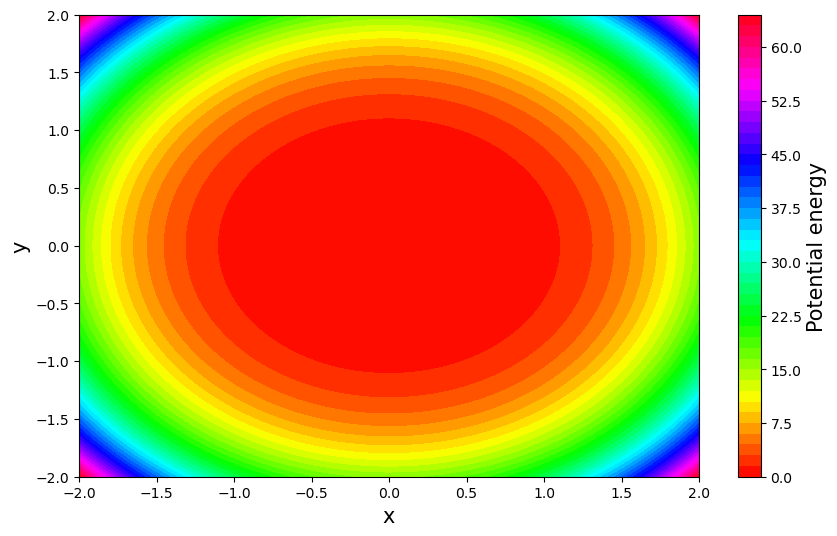

In [54]:
# First plot always takes a bit of time

xmin, xmax = -2.0, 2.0
ymin, ymax = -2.0, 2.0
xlims = xmin, xmax
ylims = ymin, ymax
xrange = range(xlims..., 200)' # Note this is a row vector
yrange = range(ylims..., 200)

fig_V, ax_V = plt.subplots(figsize=(10,6))
contourf_ = ax_V.contourf(xrange,yrange, @. V(xrange, yrange); levels=50, cmap=:hsv)
cbar = fig_V.colorbar(contourf_)
cbar.set_label(label="Potential energy", fontsize=15)
ax_V.set_xlabel("x", fontsize=15)
ax_V.set_ylabel("y", fontsize=15);

<h3>Integrating the Langevin dynamics</h3><a id='langevin'></a>

We denote by $\Delta t>0$ the time step used to integrate the various dynamics.

To numerically implement the Langevin dynamics, we first need to understand how to numerically integrate the Hamiltonian part of the dynamics, and then the OU part. For the Hamiltonian part, we use the Störmer-Verlet integrator (a.k.a. velocity verlet or leapfrog). For the OU process, we can actually solve the SDE analytically which leads to a natural discretization.


<details>
<summary>Details on the Störmer-Verlet integrator.</summary>
<h4>Störmer-Verlet algorithm</h4>

This popular integrator is a composition of the symplectic Euler A and B schemes. Given a configuration $(q^0,p^0)$ the symplectic Euler A scheme reads
$$
\tag{Euler A}
\left\lbrace
\begin{aligned}
q^1 &= q^0 + \Delta t\, M^{-1}p^0,\\
p^1 &= p^0 - \Delta t\,\nabla V(q^1),
\end{aligned}
\right.
$$
while the symplectic Euler B scheme reads
$$
\tag{Euler B}
\left\lbrace
\begin{aligned}
q^1 &= q^0 + \Delta t\, M^{-1}p^1,\\
p^1 &= p^0 - \Delta t\,\nabla V(q^0).
\end{aligned}
\right.
$$
The (velocity) Verlet integrator is a composition of half-steps of Euler B and Euler A, and therefore reads
$$
\tag{Störmer--Verlet}
(q^1,p^1)=\varphi_{\Delta t}^{\rm SV}(q^0,p^0),\qquad
\left\lbrace
\begin{aligned}
p^{1/2} &= p^0-\frac{\Delta t}{2}\nabla V(q^0)\\
q^1 &= q^0 +\Delta t\,M^{-1}p^{1/2},\\
p^1 &= p^{1/2}-\frac{\Delta t}{2}\nabla V(q^1).
\end{aligned}
\right.
$$

Overall, we can see the A step as updating the positions and the B step as updating the momenta. We shall use this notation later when naming numerical integrators based on splitting strategies:
$$
\begin{align}
\tag{A}
(q^1,p^1)&=\varphi_{\Delta t}^{\rm A}(q^0,p^0)=(q^0+\Delta t\,M^{-1}p^0, p^0),\\
\tag{B}
(q^1,p^1)&=\varphi_{\Delta t}^{\rm B}(q^0,p^0)=(q^0, p^0-\Delta t\,\nabla V(q^0)).
\end{align}
$$
We therefore write numerical flows as
$$
\varphi_{\Delta t}^{\rm SV}=\varphi_{\Delta t/2}^{\rm B}\circ\varphi_{\Delta t}^{\rm A}\circ\varphi_{\Delta t/2}^{\rm B},
$$
which indicates first a half-step (in $\Delta t$) of (B), then a full step of (A), and finally a half-step of (B).
</details>

<details>
<summary> Details on the OU process and its natural discretization. </summary>

<h4> The Ornstein-Uhlenbeck process </h4>

The analytical solution of the Ornstein-Uhlenbeck process is known: if $p_0$ is the inital momenta at time $t=0$, then the solution of the process at time $t$ is
$$
p_t = {\rm e}^{-\gamma M^{-1}t}p_0 + \sqrt{\frac{2\gamma}{\beta}}\int_{0}^t {\rm e}^{-\gamma M^{-1}(t-s)}{\rm d}W_s.
$$
This is a Gaussian process with mean ${\rm e}^{-\gamma M^{-1}t}p_0$ and covariance matrix
$$
\frac{2\gamma}{\beta}\int_{0}^t {\rm e}^{-2\gamma M^{-1}(t-s)}ds=\frac{1}{\beta}({\rm I}_{dN}-{\rm e}^{-2\gamma M^{-1}t})M.
$$
Therefore, a consistent discretization of the Ornstein-Uhlenbeck process over the time interval $[0,\Delta t]$ is
$$
\tag{O}
p^1 = {\rm e}^{-\gamma M^{-1}\Delta t}p^0 + \sqrt{\frac{\left({\rm I}_{dN}-{\rm e}^{-2\gamma M^{-1}\Delta t}\right)M}{\beta}}{\rm G}^1,\qquad {\rm G}^1\sim\mathcal{N}(0,{\rm I}_{dN}).
$$
We shall also note this update with $\varphi_{\Delta t}^{\rm O}(q^0,p^0)=(q^0,p^1)$ with $p^1$ defined above (even though this is not a numerical flow since noise is introduced).
</details>

<i>Julia particularities</i>
* The `!` at the end of the function name is a Julia convention to indicate that this function modifies the input.
* The `.` syntax after function names or before unary/binary/comparison operators means that the operation is vectorized, i.e. performed element-wise over the array. The `@.` syntax is a Julia macro that means that everything in the line is vectorized. Had we only specified `p⁰ -= Δt * ∇V⁰ / 2`, only the reference of the vector would have beed copied, not the content.
* Ensure to pass Float vectors, otherwise the computations won't work. It is made mandatory here, as the force function ($-\nabla V$) will return float values anyway.

<h4>Integrating the Hamiltonian dynamics</h4>

In [55]:
"""
    stormer_verlet!(q::Vector{<:Real}, p::Vector{<:Real}, ∇V0::Vector{:Real}, Δt, ∇V::Function)

Störmer-Verlet integrator for the Hamiltonian dynamics. (q,p) is the initial configuration, ∇V0 the current value of the gradient of the potential (i.e. ∇V0=∇V(q)), Δt the time step, ∇V function that outputs the gradient of the potential.

The configuration and the value of the gradient of V are updated in place.
"""
function stormer_verlet!(q::Vector{<:Real}, p::Vector{<:Real}, Δt, _, _, ∇V0::Vector{<:Real}, ∇V::Function)
    @. p -= Δt / 2 * ∇V0
    @. q += Δt * p
    ∇V0 .= ∇V(q) # No @. macro here, why ?
    @. p -= Δt / 2 * ∇V0
end
;

In [56]:
"""
    dynamics(q::Vector{<:Real}, p::Vector{<:Real}, Δt, β, γ, T, ∇V::Function, integrator::Function, dynamicsName::String; verbose::Bool)

Simulate the dynamics dynamicsName using an integrator, starting from the initial configuration (q,p), using a time step Δt and a total simulation time T. The gradient of the potential is given by ∇V.
The integrator must be a function with signature integrator(q::Vector, p::Vector,  Δt, β, γ, ∇V0::Vector,, ∇V::Function)

Outputs the trajectory (positions, momenta). positions and momenta are both matrices, each line corresponding to a state, and each column to a coordinate.
"""
function dynamics(q::Vector{<:Real}, p::Vector{<:Real}, Δt, β, γ, T, ∇V::Function, integrator::Function, dynamicsName::String; verbose::Bool=true)

    # Get the number of iterations
    Nit = round(Int, T/Δt)

    # Frequency of the points to show the progress of the simulations
    nlog = round(Int, Nit/10)

    # Holds the positions over time
    positions = Array{Float64,2}(undef, Nit, 2)
    positions[1,:] = q

    # Holds the momenta over time
    momenta = Array{Float64,2}(undef, Nit, 2)
    momenta[1,:] = p

    # Initial value of the gradient of the potential
    ∇V0 = ∇V(q)

    if verbose
        print("Integrating using the $dynamicsName for $(Nit) iterations\t"); flush(stdout)
    end

    for i in 2:Nit
        
        # Prints a point every nlog iterations
        if verbose && i % nlog == 0
            print("."); flush(stdout)
        end

        # Integrate one step
        integrator(q,p, Δt, β, γ, ∇V0, ∇V)

        # Update the trajectory
        positions[i,:] = q
        momenta[i,:] = p
    end
    
    if verbose
        println("\tDone"); flush(stdout)
    end
    
    return positions, momenta
end
;

In [57]:
# Parameters for the Störmer-Verlet run

T = 10000. # Simulation time
Δt = 0.01 # Time step
Nit = round(Int, T/Δt) # Number of iterations

# Initial configuration
q = [-1.5,-1.5]+3*rand(2)
p = randn(2)/sqrt(β)
#p = zeros(2)/sqrt(β)

;

In [58]:
# compute the whole trajectory
positions, momenta = dynamics(q, p, Δt, 0, 0,T, ∇V, stormer_verlet!, "Hamiltonian dynamics")

x = positions[:,1]
y = positions[:,2]
;

Integrating using the Hamiltonian dynamics for 1000000 iterations	..........	Done


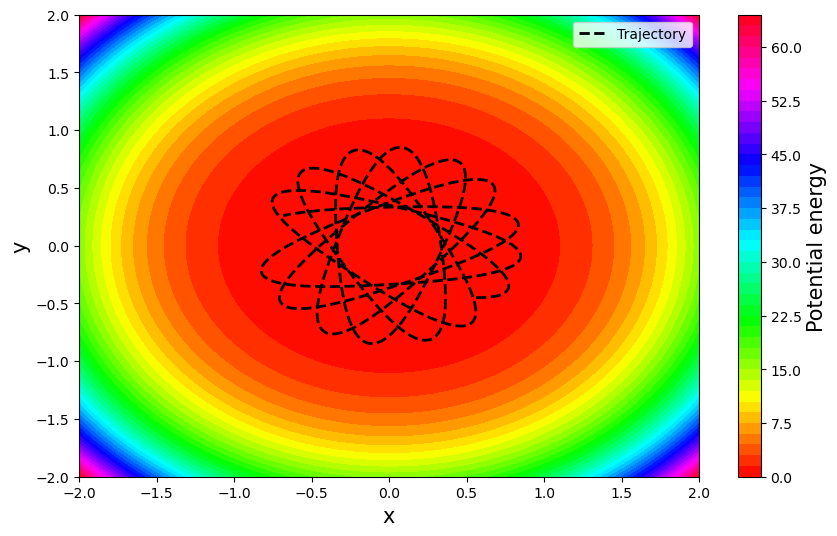

In [59]:
# Plot only the beginning of the trajectory
Nmax = min(3000,length(x))
plt.figure(fig_V)
# Remove previous data 
for data in ax_V.lines
    data.remove()
end
ax_V.plot(x[1:Nmax],y[1:Nmax],label="Trajectory", linestyle="dashed", color=:black, linewidth=2)
ax_V.legend();


Always perform sanity checks ! The Hamiltonian should be very well preserved troughout the trajectory.

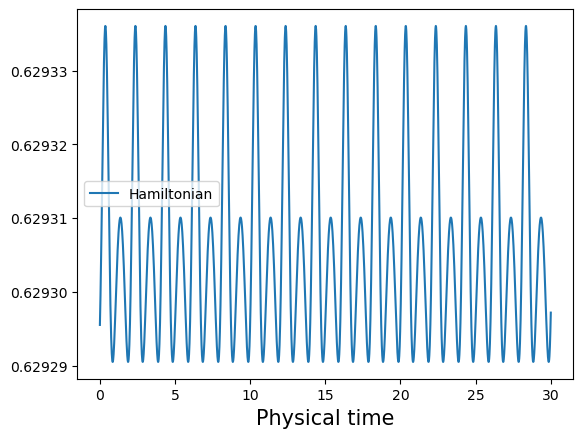

In [60]:
# Plot the Hamiltonian over time

fig, ax = plt.subplots()
ax.plot(collect(1:Nmax)*Δt, [hamiltonian(positions[i,:], momenta[i,:], V) for i in 1:Nmax], label="Hamiltonian")
ax.set_xlabel("Physical time", fontsize=15)
ax.legend()
display(gcf())
plt.close(fig)

<b><u>Tasks.</b></u> 
* Observe how the initial configuration impacts the whole trajectory. What happens when you set the initial momenta to 0 ?

```diff
- When the initial momenta is set to 0, the particle is trapped following a one-dimensional dynamics, resembling an oscillator.
```

* Check that the variations of the Hamiltonian scale with $\Delta t^2$ by running trajectories and plotting the variations w.r.t. $\Delta t$.

Integrating using the Hamiltonian dynamics for 33750 iterations	..........	Done
Integrating using the Hamiltonian dynamics for 50625 iterations	..........	Done
Integrating using the Hamiltonian dynamics for 75938 iterations	.........	Done
Integrating using the Hamiltonian dynamics for 113906 iterations	.........	Done
Integrating using the Hamiltonian dynamics for 170859 iterations	.........	Done
Integrating using the Hamiltonian dynamics for 256289 iterations	.........	Done
Integrating using the Hamiltonian dynamics for 384434 iterations	..........	Done
Integrating using the Hamiltonian dynamics for 576650 iterations	..........	Done
Integrating using the Hamiltonian dynamics for 864976 iterations	.........	Done
Integrating using the Hamiltonian dynamics for 1297463 iterations	..........	Done
Integrating using the Hamiltonian dynamics for 1946195 iterations	.........	Done


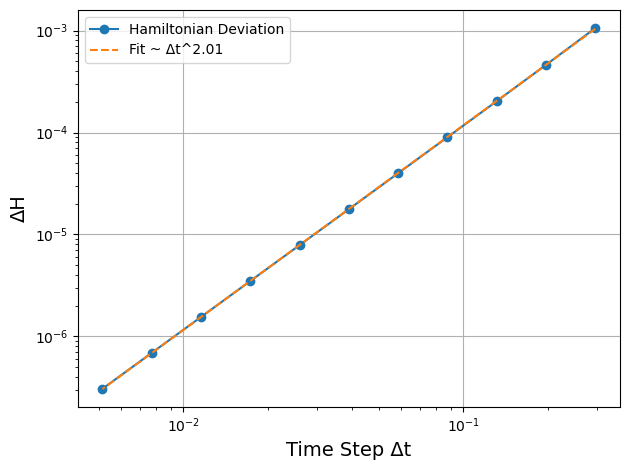

In [61]:
Δts = 1.5 .^ (-3:-1:-13)
q = [-1.5,-1.5]+3*rand(2)
p = randn(2)/sqrt(β)

hamiltonian_variations = Float64[]

for Δt in Δts
    positions, momenta = dynamics(q, p, Δt, 0, 0, T, ∇V, stormer_verlet!, "Hamiltonian dynamics")
    hamiltonians = [hamiltonian(positions[i, :], momenta[i, :], V) for i in 1:Nmax]
    variations = maximum(hamiltonians) - minimum(hamiltonians)
    push!(hamiltonian_variations, variations)
end

log_Δts = log.(Δts)
log_vars = log.(hamiltonian_variations)
poly_fit = Polynomials.fit(log_Δts, log_vars, 1)  
slope = round(poly_fit.coeffs[2], digits=2)

# Plotting
fig, ax = plt.subplots()
ax.plot(Δts, hamiltonian_variations, "o-", label="Hamiltonian Deviation")
ax.plot(Δts, exp.(poly_fit.(log_Δts)), "--", label="Fit ~ Δt^$slope")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time Step Δt", fontsize=14)
ax.set_ylabel("ΔH", fontsize=14)
ax.legend()
ax.grid(true)
fig.tight_layout()
display(fig)
plt.close(fig)


<h4>Integrating the OU process</h4>

In [62]:
"""
    OU_exact!(p::Vector{<:Real}, Δt, β, γ)

Exact integration of the Ornstein-Uhlenbeck process. p is the initial momenta, Δt the time step, β the inverse temperature, γ the friction parameter, G is drawn from the standard Gaussian distribution.

The momenta is updated in place.
"""
function OU_exact!(_, p::Vector{<:Real}, Δt, β, γ, _, _)
    p .= exp(-γ*Δt) .* p .+ sqrt((1-exp(-2*γ*Δt))/β) .* randn(size(p))
end
;

In [63]:
# Parameters for the OU run

T = 10000. # Simulation time
Δt = 0.01 # Time step
Nit = round(Int, T/Δt) # Number of iterations
γ = 1. # Friction parameter

# Initial configuration
p = randn(2)/sqrt(β)
;

In [64]:
# Compute the whole trajectory
# Note that the initial position is not used in the OU dynamics
_, momenta = dynamics([0.0, 0.0], p, Δt, β, γ, T, ∇V, OU_exact!, "Ohrnstein-Uhlenbeck exact")
;

Integrating using the Ohrnstein-Uhlenbeck exact for 1000000 iterations	..........	Done


Always perform sanity checks ! Here, each component of the momenta should be Gaussian distributed, with mean zero and variance $\beta^{-1}$.

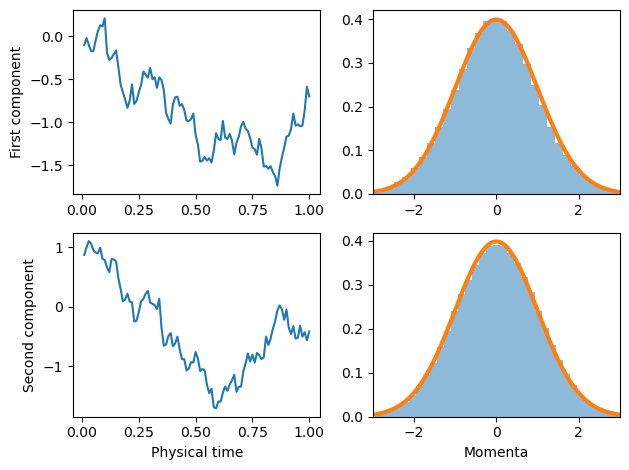

In [65]:
xlims = -3/sqrt(β), 3/sqrt(β)
ylims = -3/sqrt(β), 3/sqrt(β)
xrange = range(xlims..., 200)
yrange = range(ylims..., 200)
Nmax = 100

fig, ax = plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = ax

ax1.plot(collect(1:Nmax)*Δt,momenta[1:Nmax,1],label=L"
")
ax1.set_ylabel("First component")

ax2.plot(collect(1:Nmax)*Δt,momenta[1:Nmax,2],label=L"
")
ax2.set_xlabel("Physical time")
ax2.set_ylabel("Second component")

ax3.hist(momenta[:,1],bins=50,density=true,alpha=0.5,label=L"
 histogram")
ax3.plot(xrange, standard_gaussian.(xrange), label="",linewidth=3)
ax3.set_xlim(xlims)

ax4.hist(momenta[:,2],bins=50,density=true,alpha=0.5,label=L"
 histogram")
ax4.plot(yrange, standard_gaussian.(yrange), label="",linewidth=3)
ax4.set_xlim(xlims)
ax4.set_xlabel("Momenta")

fig.tight_layout()
display(gcf())
plt.close(fig)

<h3>A splitting strategy</h3>

A popular way to integrate the Langevin dynamics is based on a splitting strategy, considering separately the OU process and the Hamiltonian dynamics. We provide below one possible choice, named the BAOAB integrator.

<details>
<summary>Why the name 'BAOAB' ?</summary>

See first the details blocks in [this cell](#langevin). As hinted by the letters, it performs a half B step, a half A step, a full O step, and then again a half A step and half B step:
$$
\varphi_{\Delta t}^{\rm BAOAB}=\varphi_{\Delta t/2}^{\rm B}\circ\varphi_{\Delta t/2}^{\rm A}\circ\varphi_{\Delta t}^{\rm O}\circ\varphi_{\Delta t/2}^{\rm A}\circ\varphi_{\Delta t/2}^{\rm B}.
$$
</details>

In [66]:
"""
    BAOAB!(q::Vector{<:Real}, p::Vector{<:Real}, Δt, β, γ, ∇V::Function, ∇V0::Vector{<:Real})

BAOAB integrator for the Langevin dynamics. (q,p) is the initial configuration, Δt the time step, β the inverse temperature, γ the friction parameter, ∇V the negative force field, ∇V the gradient of V evaluated at (q,p). The Ornstein-Uhlenbeck process is integrated using the analytical expression of the solution.

The configuration and the gradient of the potential are updated in place.
"""
function BAOAB!(q::Vector{<:Real}, p::Vector{<:Real}, Δt, β, γ, ∇V0::Vector{<:Real}, ∇V::Function)
    @. p -= Δt * ∇V0 / 2
    @. q += Δt * p / 2
    p .= exp(-γ*Δt) .* p .+ sqrt((1-exp(-2*γ*Δt))/β) .* randn(size(p))
    @. q += Δt * p / 2
    ∇V0 .= ∇V(q)
    @. p -= Δt * ∇V0 / 2
end
;

In [67]:
# Parameters for the BAOAB run

T = 2500. # Simulation time
Δt = 0.1 # Time step
γ = 1.0 # Friction parameter
Nit = round(Int, T/Δt) # Number of iterations

# Initial configuration
q = [-1.5,-1.5]+3*rand(2)
p = randn(2)/sqrt(β)
;

In [68]:
# Compute the whole trajectory

positions, momenta = dynamics(q, p, Δt, β, γ, T, ∇V, BAOAB!, "Langevin Dynamics")

x = positions[:,1]
y = positions[:,2]
;

Integrating using the Langevin Dynamics for 25000 iterations	..........	Done


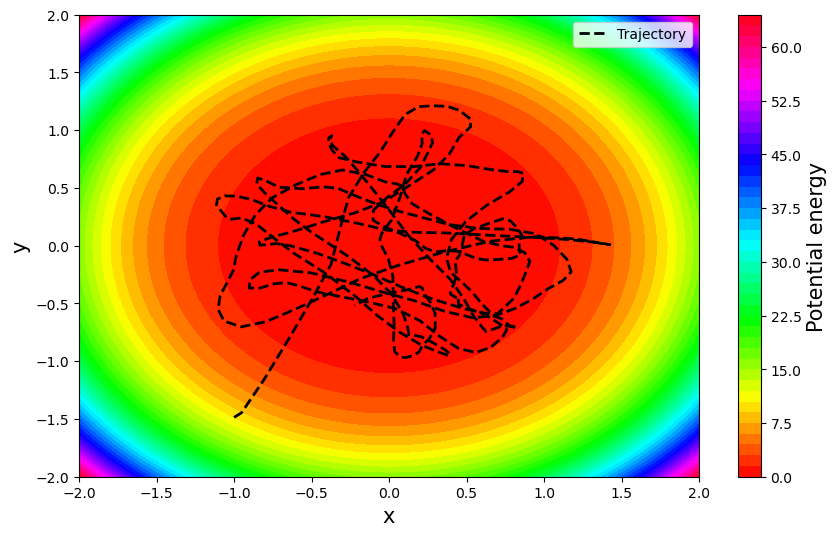

In [69]:
# Plot only beginning of the trajectory
Nmax = min(300,length(x))
plt.figure(fig_V)
# Remove previous data  
for data in ax_V.lines
    data.remove()
end
ax_V.plot(x[1:Nmax],y[1:Nmax],label="Trajectory", linestyle="dashed", color="black", linewidth=2)
# Reset ax limits in case of the previous trajectory went out of the contourf
ax_V.set_xlim(xmin, xmax)
ax_V.set_ylim(ymin, ymax);

<h3>Some sanity checks</h3>

* the total energy of the system over time, <i>i.e.</i> the Hamiltonian, should not blow up;
* the momenta should be normally distributed;
* we can visualize the sampling on position and compare it with the reference.

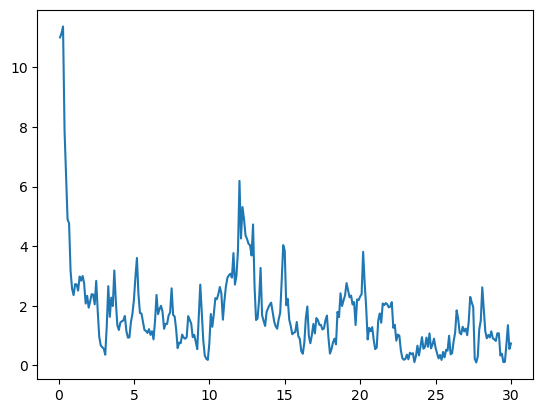

In [70]:
# Energy plot

fig, ax = plt.subplots()
ax.plot(collect(1:Nmax)*Δt, [hamiltonian(positions[i,:], momenta[i,:], V) for i in 1:Nmax], label="Hamiltonian")
display(gcf())
plt.close(fig)

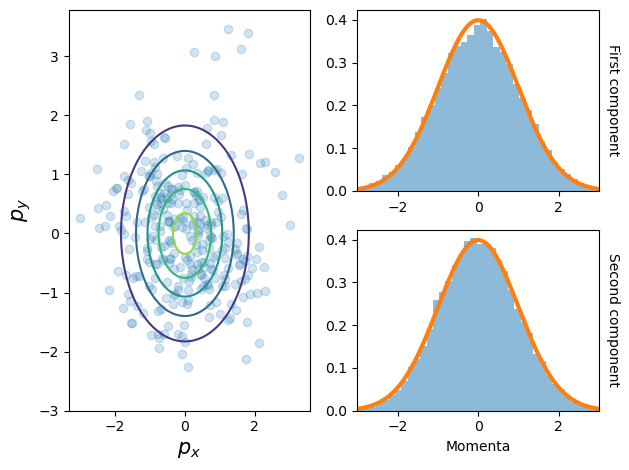

In [71]:
# Momena equilibrium distribution
xlims = -3/sqrt(β), 3/sqrt(β)
ylims = -3/sqrt(β), 3/sqrt(β)
xrange = range(xlims..., 200)'
yrange = range(ylims..., 200)

fig, ax = plt.subplot_mosaic([["one", "two"], ["one", "three"]])
ax["one"].scatter(momenta[1:Nmax,1],momenta[1:Nmax,2],label="",alpha=0.2)
ax["one"].contour(xrange, yrange, @. standard_gaussian(xrange, yrange); levels=5)
ax["one"].set_xlabel(L"p_x", fontsize=15)
ax["one"].set_ylabel(L"p_y", fontsize=15)

ax["two"].hist(momenta[:,1],bins=50,density=true,alpha=0.5,label=L"$p_x$ histogram")
ax["two"].plot(xrange, dropdims(standard_gaussian.(xrange), dims=1), label="",linewidth=3)
ax["two"].set_xlim(xlims)
ax["two"].set_ylabel("First component",rotation=-90,labelpad=15)
ax["two"].yaxis.set_label_position("right")

ax["three"].hist(momenta[:,2],bins=50,density=true,alpha=0.5,label=L"$p_y$ histogram")
ax["three"].plot(yrange, standard_gaussian.(yrange), label="",linewidth=3)
ax["three"].set_xlim(xlims)
ax["three"].set_xlabel("Momenta")
ax["three"].set_ylabel("Second component",rotation=-90,labelpad=15)
ax["three"].yaxis.set_label_position("right")

fig.tight_layout()
display(gcf())
plt.close(fig)

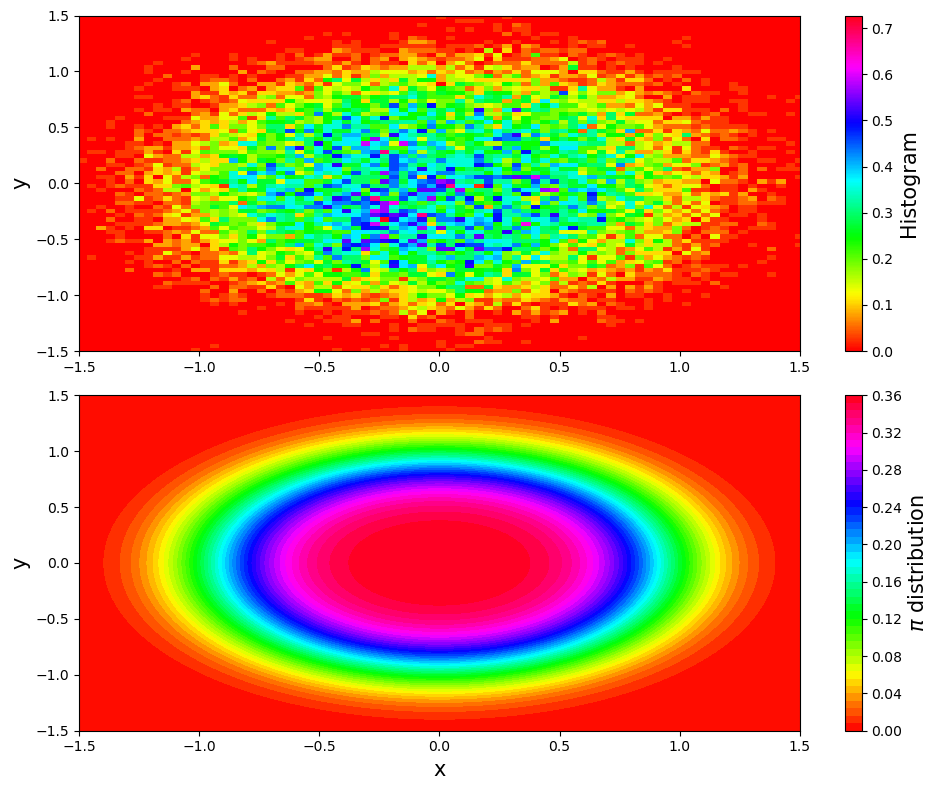

In [72]:
# Visualize the position sampling

xlims = -1.5, 1.5
ylims = -1.5, 1.5
xrange = range(xlims..., 500)
yrange = range(ylims..., 500)

fig, ax = plt.subplots(2, figsize=(10,8))
ax1, ax2 = ax
h = ax1.hist2d(positions[:,1],positions[:,2],cmap=:hsv,bins=80, density=true)
ax1.set_xlim(xlims)
ax1.set_ylim(ylims)
ax1.set_ylabel("y", fontsize=15)
cbar = plt.colorbar(h[4], ax=ax1)
cbar.set_label(label="Histogram", fontsize=15)

h = ax2.contourf(xrange, yrange, @. boltzmann_gibbs(xrange', yrange, V); cmap=:hsv, levels=50)
ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("y", fontsize=15)
cbar = fig.colorbar(h)
cbar.set_label(label=L"$\pi$ distribution", fontsize=15)

fig.tight_layout()
display(gcf())
plt.close(fig)

<h3>Convergence analysis</h3>

The trajectorial average obtained from the Langevin dynamics yields an approximation of the target thermodynamic coefficient: if $(q^i,p^i)_{i}$ are the obtained samples, it holds
$$
\frac{1}{\rm N_{it}}\sum_{i=1}^{\rm N_{it}}f(q^i,p^i)\approx \int_{\mathbb{R}^2\times\mathbb{R}^2} f(q,p)\mu(\mathrm{d}q\,\mathrm{d}p)
$$
In particular, if the observable $f:q\mapsto f(q)$ only depends on the position $q$, then an estimator of $\int_{\mathbb{R}^2} f\mathrm{d}\pi$ is
$$
\frac{1}{\rm N_{it}}\sum_{i=1}^{\rm N_{it}}f(q^i).
$$

To observe this, we define the observable $f(q)\equiv f(x,y)=\cos(xy)\exp(-y^2\sin(x))$.

In [73]:
# Define the observable, which only depends on the position
function f(x,y)
    return cos(x*y)*exp(-y^2*sin(x))
end

function f(q::Vector{<:Real})
    return f(q...)
end
;

In [74]:
# Compute reference value
mean_f, err = hcubature(q->f(q)*boltzmann_gibbs(q, V), (-10,-10),(10,10));

In [75]:
# Asymptotic convergence 

# Positions is a (N_it, 2) matrix, so we apply f row per row using mapslices, and then drop the irrelevent leftover dimension to obtain a vector
f_vals = dropdims(mapslices(f, positions, dims=[2]), dims=2)

# cumsum returns the vector of cumulative sums of values in the vector f_vals
estimator = cumsum(f_vals) ./ (1:Nit);

In [76]:
println("The reference value is:\t\t\t\t $(mean_f) ± $(err)")
println("The estimation at the end of the dynamics is:\t $(estimator[end])") 

The reference value is:				 0.982198116065317 ± 9.813174310187966e-9
The estimation at the end of the dynamics is:	 0.9808521378447671


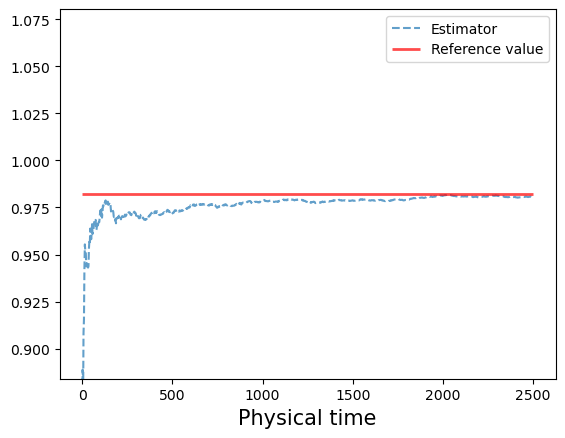

In [77]:
# Plot the estimation over time

npoints = ceil(Nit/1000)
period = round(Int, npoints) # To plot every nth point
xrange = collect(1:Nit)*Δt

fig, ax = plt.subplots()
ax.plot(xrange[begin:period:end], estimator[begin:period:end], label="Estimator", linestyle="dashed", alpha=0.7)
ax.hlines([mean_f], xmin=0, xmax=Nit*Δt, label="Reference value", color="red", linewidth=2, alpha=0.7)
ax.set_xlabel("Physical time", fontsize=15)
ax.legend()
ax.set_ylim(ymin=0.9*mean_f, ymax=1.1*mean_f) # Restrict the y axis to observe the fluctuations
display(gcf())
plt.close(fig)

<b><u>Task.</b></u>

* Compute the average pressure of the system, given by $\mathbb{E}_\pi\left[-q\cdot\nabla V(q)\right]$. Compare with the reference value.
* <b>[ONLY IF YOU HAVE TIME]</b> Compute the heat capacity $\left(\mathbb{E}_\mu\left[H^2\right]-\mathbb{E}_\mu\left[H\right]^2\right)/(k_BT^2)$. Recall that $\beta =(k_BT)^{-1}$ (you may go to [this cell](#boltzmanngibbs) to define $\beta$ as a function of $k_B,T$, or redefine it in you particular cell, but do remember you changed it there !)

In [78]:
function pressure(x, y)
    return - [x, y]' * ∇V(x, y)
end 

function pressure(q::Vector{<:Real})
    return pressure(q...)
end

mean_pressure, err = hcubature(q->pressure(q)*boltzmann_gibbs(q, V), (-10,-10),(10,10));
pressure_vals = dropdims(mapslices(pressure, positions, dims=[2]), dims=2)
estimator_pressure = cumsum(pressure_vals) ./ (1:Nit);

println("The reference value is:\t\t\t\t $(mean_pressure) ± $(err)")
println("The estimation at the end of the dynamics is:\t $(estimator_pressure[end])") 

The reference value is:				 -2.0000000005131406 ± 1.9979008463086765e-8
The estimation at the end of the dynamics is:	 -2.0461796363893123


In [79]:
H_vals = [hamiltonian(positions[i, :], momenta[i, :], V) for i in 1:Nit]
mean_H = mean(H_vals)
mean_H2 = mean(H_vals .^ 2)
heat_capacity = β^2 * (mean_H2 - mean_H^2)

println("Heat capacity estimate: $heat_capacity")

Heat capacity estimate: 1.5456401160597917


<h3>Variance analysis</h3>

The built estimator is $\widehat{f}_{\Delta t,\mathrm{N_{it}}}=\frac{1}{\rm N_{it}}\sum_{i=1}^{\rm N_{it}}f(q^n_{\Delta t})$ depends on the number of iterations $\rm N_{it}$ and the time step $\Delta t$. In this section, we focus on the fluctation errors of the estimators with respect to $\rm N_{it}$, and completely disregard errors because of the bias induced by using a positive time step.

The fluctuations around the target value are dictated by a central limit theorem (CLT): assuming the initial configuration $q^1$ is sampled under $\pi$, the quantity $\mathrm{N_{it}}\mathbb{V}_{\pi}\left[\widehat{f}_{\rm N_{it}}\right]$ is equal to
$$
\sigma^2_{f,\mathrm{N_{it}}}:=\mathbb{E}_\pi\left[\left(\Pi f\right)^2\right]+2\sum_{2\leqslant n\leqslant \mathrm{N_{it}}}\left(1-\frac{n-1}{\mathrm{N_{it}}}\right)\mathbb{E}_\pi\left[\Pi f(q^{n})\Pi f(q^1)\right],
$$
which converges to the asymptotic variance defined by
$$
\sigma^2_f := \mathbb{E}_\pi\left[\left(\Pi f\right)^2\right]+2\sum_{n=2}^{+\infty}\mathbb{E}_\pi\left[\Pi f(q^{n})\Pi f(q^1)\right],
$$

We can estimate this value by computing the correlation time or equivalently the effective sample size (ESS) to extract (approximate) i.i.d samples. A CLT-like formula can then be estimated to obtain a confidence interval. This ESS therefore also depends on the observable.

There are several methods in the literature to compute effective sample sizes (ESS). One can compute autocorrelation functions or use batch estimators of the variance. Here, we will use the _initial positive sequence_ (IPS) estimator. We refer to [here](https://arxiv.org/pdf/0906.0943) and [here](https://arxiv.org/pdf/1011.0175) for more methods and details. 

<details><summary>How is the IPS estimator defined ?</summary>

A formula for the autocorrelation time is 
$$
\tau = 1+2\sum_{k=1}^{+\infty}\rho_k,
$$
where $\rho_k$ is the ACF function of the series at lag $k$. It can be shown that the sums of pairs of consecutive values $\rho_i+\rho_{i+1}$ are always positive. We therefore compute the ACF values and truncate the sum when the sum of the observed pairs become negative.
</details>

If the observable is vector-valued (for instance we want to observe the cross-correlations between the x and y components), one can resort to computing the minimum of the ESS on each coordinate, or even better, use the ESS formula defined in Vats <i>et al.</i> (2019) (see [here](https://github.com/rsantet/multiESS) for a basic Julia implementation). This method actually uses variance mini-batching estimators.

In [80]:
# Parameters for the ESS computations

T = 10000. # Simulation time. We decrease it to perform more runs.
Δt = 0.01 # Time step
γ = 1.0 # Friction parameter
Nit = round(Int, T/Δt) # Number of iterations

# Initial configuration
q = [-1.5,-1.5]+3*rand(2)
p = randn(2)/sqrt(β)
;

In [81]:
positions, momenta = dynamics(q, p, Δt, β, γ, T, ∇V, BAOAB!, "", verbose=false);

In [82]:
lags = collect(0:250)

acf = autocor(positions, lags)
acf_p = autocor(momenta, lags)
acf_f = autocor(f_vals, lags);

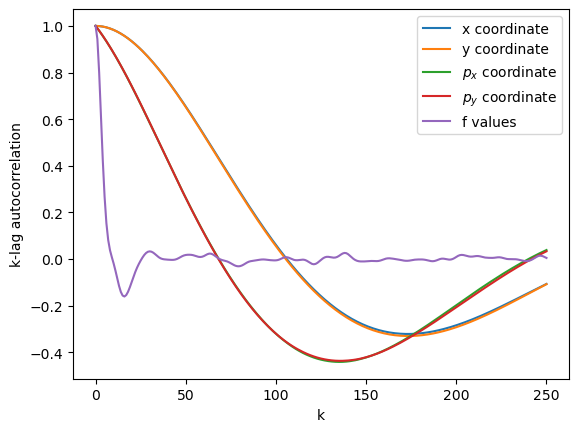

In [83]:
# Autocorrelations visualization

fig, ax = plt.subplots()
ax.plot(lags, acf[:,1], label="x coordinate")
ax.plot(lags, acf[:,2], label="y coordinate")
ax.plot(lags, acf_p[:,1], label=L"$p_x$ coordinate")
ax.plot(lags, acf_p[:,2], label=L"$p_y$ coordinate")
ax.plot(lags, acf_f, label="f values")
ax.set_xlabel("k")
ax.set_ylabel("k-lag autocorrelation")
ax.legend()
display(gcf())
plt.close(fig)

In [84]:
# This function outputs the index for which we need to truncate the ACF sum
# This is based on a criterion about sum of pairs in the ACF values

function ips_index(acf_values)
    n = length(acf_values)
    idx = 1
    while idx < n
        if acf_values[idx]+acf_values[idx+1]<=0
            return idx+1
        end
        idx += 2
    end
    # If we're here, then we have not seen sum of pairs becoming negative
    # The best we can is using the full acf_values
    return n
end

function correlation_time(acf_values)
    index = ips_index(acf_values)
    τ = 1+2*sum(acf[begin:index])
    return τ
end
;

In [85]:
ESS_x = round(Int, Nit / correlation_time(acf[:,1]))
ESS_y = round(Int, Nit / correlation_time(acf[:,2]))
ESS_px = round(Int, Nit / correlation_time(acf_p[:,1]))
ESS_py = round(Int, Nit / correlation_time(acf_p[:,2]))
ESS_f = round(Int, Nit / correlation_time(acf_f));

In [86]:
println("Effective sample size for the x component is:\t$(ESS_x)")
println("Effective sample size for the y component is:\t$(ESS_y)")
println("Effective sample size for the px component is:\t$(ESS_px)")
println("Effective sample size for the py component is:\t$(ESS_py)")
println("Effective sample size for the f values is:\t$(ESS_f)")
println()

std_estimator = sqrt(var(estimator)/ESS_f)
println("∫fdπ value using quadrature method is:\t\t$(mean_f) ± $(err)")
println("∫fdπ value using the IPS estimator is:\t\t$(estimator[end]) ± $(std_estimator)")

Effective sample size for the x component is:	7990
Effective sample size for the y component is:	7990
Effective sample size for the px component is:	9047
Effective sample size for the py component is:	9047
Effective sample size for the f values is:	40280

∫fdπ value using quadrature method is:		0.982198116065317 ± 1.9979008463086765e-8
∫fdπ value using the IPS estimator is:		0.9808521378447671 ± 3.840857798927284e-5


<b><u>Task.</b></u> 
* <b>[ONLY IF YOU HAVE TIME]</b> Change the parameters ($\beta, \Delta t, \gamma, T, \dots$) and see how it impacts the estimation and its variance. Beware of the computation time.
* <b>[ONLY IF YOU HAVE TIME]</b> Run simulations for different initial conditions and estimate the variance after a fixed number of steps. Add a thermalization step beforehand so that the configuration is approximately a sample under the Boltzmann-Gibbs distribution.

In [87]:
T_mixing = 100. 

# Initial configuration
q = [-1.5,-1.5]+3*rand(2)
p = randn(2)/sqrt(β)

# Mixing
q, p = dynamics(q, p, Δt, β, γ, T_mixing, ∇V, BAOAB!, "", verbose=false);

# Computation of the full trajectory
T_simu = 100.
positions, momenta = dynamics(q[end, :], p[end, :], Δt, β, γ, T_simu, ∇V, BAOAB!, "", verbose=false);

acf_f = autocor(f_vals, lags);
ESS_f = round(Int, Nit / correlation_time(acf_f));
std_estimator = sqrt(var(estimator)/ESS_f)
println("∫fdπ value using quadrature method is:\t\t\t$(mean_f) ± $(err)")
println("∫fdπ value using the IPS estimator after mixing is:\t$(estimator[end]) ± $(std_estimator)")

∫fdπ value using quadrature method is:			0.982198116065317 ± 1.9979008463086765e-8
∫fdπ value using the IPS estimator after mixing is:	0.9808521378447671 ± 3.840857798927284e-5


<h2>A metastable system</h2>

We now consider another potential energy function $V$ which writes
$$
\tag{Entropic switch}
V(q)\equiv V(x,y)=3{\rm e}^{-x^2}({\rm e}^{-(y-1/3)^2}-{\rm e}^{-(y-5/3)^2})-5{\rm e}^{-y^2}({\rm e}^{-(x-1)^2}+{\rm e}^{-(x+1)^2})+0.2x^4+0.2(y-1/3)^4.
$$
The potential energy function $V$ has two deep wells centered at $q_{\rm L}=(-1.048, -0.04210),q_{\rm R}=(1.048, -0.04210)$, and a shallow well around $q_{\rm S}=(0., 1.5371)$. This potential energy surface is such that the Langevin dynamics exhibit **metastability**: the dynamics stay trap for long times in a given potential well before exiting to another well. This impacts the accuracy of the estimator.

In [88]:
# Definitions of the potential and its gradient

"""
    entropic_switch(x, y)

Potential energy function.
"""
function entropic_switch(x, y)
    tmp1 = x^2
    tmp2 = (y - 1 / 3)^2
    return 3 * exp(-tmp1) * (exp(-tmp2) - exp(-(y - 5 / 3)^2)) - 5 * exp(-y^2) * (exp(-(x - 1)^2) + exp(-(x + 1)^2)) + 0.2 * tmp1^2 + 0.2 * tmp2^2
end

function entropic_switch(q::Vector{<:Real})
    return entropic_switch(q...)
end

"""
    ∇entropic_switch(x, y)

Gradient of the potential energy function.
"""
function ∇entropic_switch(x, y)

    tmp1 = exp(4*x)
    tmp2 = exp(-x^2 - 2*x - y^2 - 1)
    tmp3 = exp(-x^2)
    tmp4 = exp(-(y-1/3)^2)
    tmp5 = exp(-(y-5/3)^2)

    dx = 0.8*x^3 + 10*(tmp1*(x - 1) + x + 1)*tmp2 - 6*tmp3*x*(tmp4 - tmp5)

    dy = 10*(tmp1 + 1)*y*tmp2 + 3*tmp3*(2*tmp5*(y - 5/3) - 2*tmp4*(y - 1/3)) + 0.8*(y - 1/3)^3

    return [dx, dy]
end

function ∇entropic_switch(q::Vector{<:Real})
    return ∇entropic_switch(q...)
end
;

<h3>Visualizing the potential energy surface (PES)</h3>

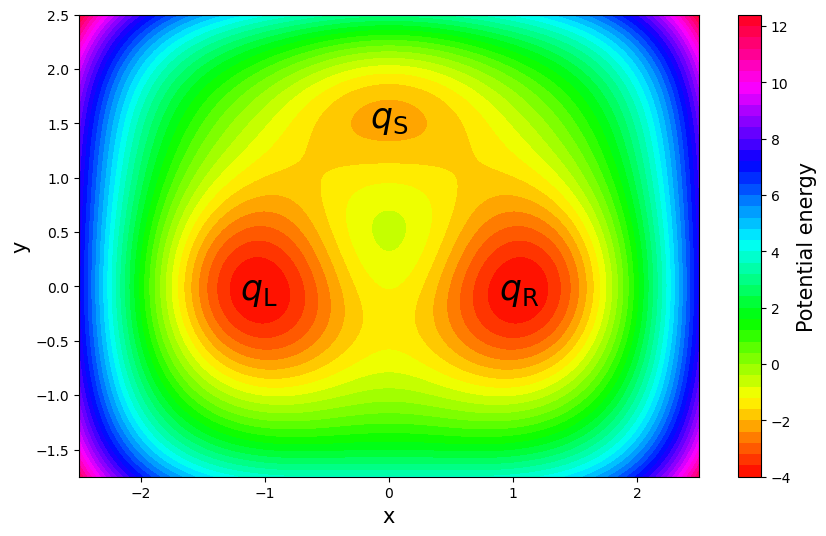

In [89]:
# First time compiling the PyPlot library takes a bit of time
using PyPlot

xmin, xmax = -2.5, 2.5
ymin, ymax = -1.75, 2.5
xlims = xmin, xmax
ylims = ymin, ymax
xrange = range(xlims..., 200)' # Note this is a row vector
yrange = range(ylims..., 200)

fig_V, ax_V = plt.subplots(figsize=(10,6))
contourf_ = ax_V.contourf(xrange,yrange, @. entropic_switch(xrange, yrange); levels=50, cmap=:hsv)
cbar = fig_V.colorbar(contourf_)
cbar.set_label(label="Potential energy", fontsize=15)
ax_V.set_xlabel("x", fontsize=15)
ax_V.set_ylabel("y", fontsize=15)
kwargs = Dict(:fontsize=>25, :ha=>"center", :va=>"center")
ax_V.text(-1.048, -0.04210, L"$q_{\rm L}$"; kwargs...)
ax_V.text(1.048, -0.04210, L"$q_{\rm R}$"; kwargs...)
ax_V.text(0., 1.5371, L"$q_{\rm S}$"; kwargs...);

We now run Langevin dynamics.

In [90]:
# Compute the whole trajectory
# Parameters for the BAOAB run

T = 2500. # Simulation time
Δt = 0.01 # Time step
γ = 1.0 # Friction parameter
Nit = round(Int, T/Δt) # Number of iterations
β = 1.

# Initial configuration
q = [-2,-1.5]+4*rand(2)
p = randn(2)/sqrt(β)
;
positions, momenta = dynamics(q, p, Δt, β, γ, T, ∇entropic_switch, BAOAB!, "Langevin Dynamics")

x = positions[:,1]
y = positions[:,2]
;

Integrating using the Langevin Dynamics for 250000 iterations	..........	Done


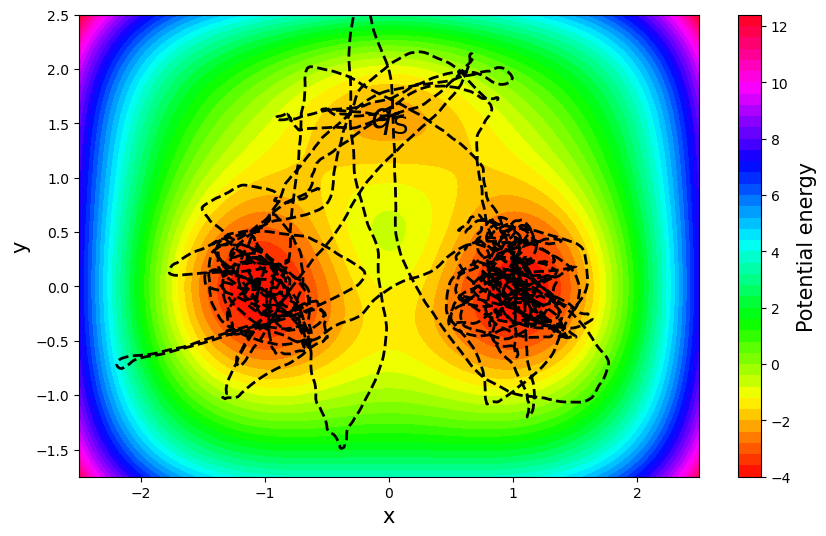

In [91]:
# Plot only beginning of the trajectory
Nmax = min(10000,length(x))
plt.figure(fig_V)
# Remove previous data  
for data in ax_V.lines
    data.remove()
end
ax_V.plot(x[1:Nmax],y[1:Nmax],label="Trajectory", linestyle="dashed", color="black", linewidth=2)
# Reset ax limits in case of the previous trajectory went out of the contourf
ax_V.set_xlim(xmin, xmax)
ax_V.set_ylim(ymin, ymax);

To observe the metastability in the $x$ direction, we can define the reaction coordinate $\xi$ defined as $\xi(x,y)=x$. The free energy associated with $\xi$ is defined as
$$
F(x)=-\beta^{-1}\ln \int_{\mathbb{R}}{\rm e}^{-\beta V(x,y)}{\rm d}y.
$$
The histogram of the $x$ values should superimpose with the free energy distribution, whose density is proportional to $\mathrm{e}^{-\beta F(x)}$.

In [92]:
# Compute various normalization constants for values of the reaction coordinate (x) on a grid
n_x = 200
x_grid = range(-2.5,2.5,n_x)
free_energy = zeros(n_x)
for idx in 1:n_x
    free_energy[idx] = -log(hquadrature(y-> boltzmann_gibbs_unnormalized(x_grid[idx],y, entropic_switch), -10, 10)[1])/β
end

# Estimation of the free energy by a piecewise constant function
function gibbs_free_energy(x)
    if x <= -2.5
        return free_energy[1]
    elseif x >= 2.5
        return free_energy[end]
    else
        idx = trunc(Int,(x+2.5)/5*n_x)+1
        return free_energy[idx]
    end
end
;

In [93]:
# Compute the free energy for for the simulation
x_coords = positions[:,1]
fe_x = gibbs_free_energy.(x_grid)
;

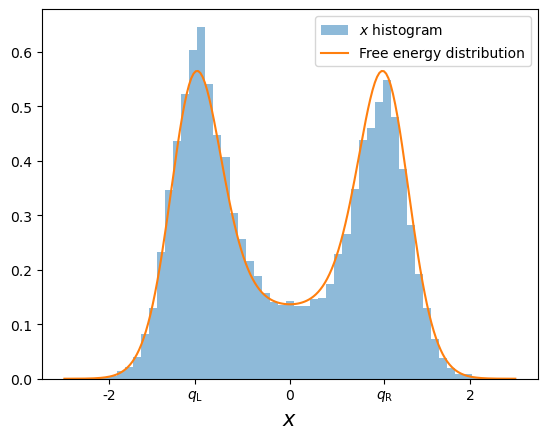

In [94]:
# Compare with the histogram of the x-coordinate histogram

# The partition function needs to be computed for this new example
Zπ, err = hcubature(q->boltzmann_gibbs_unnormalized(q, entropic_switch), (-10,-10),(10,10))
#println("Value of ∫exp(-βV)dπ using a quadrature method is $(Zπ) ± $(err)")

xlims = -2.5, 2.5
xrange = range(xlims...,200)

fig, ax = plt.subplots()
ax.hist(x_coords,bins=50,alpha=0.5,density=true,label=L"$x$ histogram")
ax.plot(x_grid, @. exp(-β * fe_x) / Zπ; label="Free energy distribution")
ax.set_xticks([-2,-1.048,0,1.048,2],["-2",L"$q_{\rm L}$", "0", L"$q_{\rm R}$", "2"])
ax.tick_params(labelsize=10)
ax.set_xlabel(L"$x$", fontsize=15)
ax.legend()
display(gcf())
plt.close(fig)

<b><u>Tasks.</u> Play around with the hyperparameters ($\Delta t,T$) and the system's parameters ($\beta,\gamma$).</b>
* What happens when $\beta\uparrow$ ? When $\beta\downarrow$ ? Interpret, recalling that $\beta^{-1}=k_b T_{\rm hb}$ where $k_b$ is the Boltzmann's constant and $T_{\rm hb}$ is the temperature of the heat bath.

```diff
- When the temperature is small, the particle struggles to overcome energy barriers impacting negatively the sampling quality. On the contrary, when the temperature is large, the particle is able to move freely on the PES and easily locate the regions of high-probability under the Boltzmann-Gibbs distribution
```

* What happens when $\gamma\uparrow$ ? When $\gamma\downarrow$ ? Interpret, recalling the form of the [Langevin dynamics](#langevin).

```diff 
- When the friction is large, the dynamics diffuses more and its behavior resembles the overdamped Langevin dynamics. It loses its `ballistic' characteristic and it is harder to navigate on the PES. On the other hand, if the friction is small, the dynamics resembles the Hamiltonian dynamics and follows level sets of Hamiltonian. Moving along various level sets of the Hamiltonian becomes difficult, negatively impacting the sampling efficiency.  
```

<h3>Time step bias</h3>

The Langevin dynamics needs to be discretized with a positive time step $\Delta t$. This induces some bias in the distribution, with error of order $\Delta t$. This is a bit difficult to observe in practice, and is usually negligible in MD simulations (the time step is as small as femtoseconds).

<b><u>Task</b></u>. By copying the code at the beginning of the notebook, observe the equilibrium distribution of the momenta as the time step varies for this example. The value $\Delta t=0.5$ should be a sweet spot to observe some bias.

Integrating using the Langevin Dynamics for 200000 iterations	..........	Done


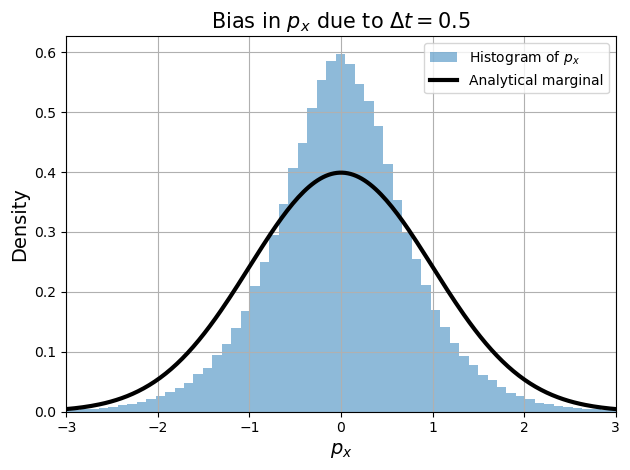

In [95]:
Δt = 0.5  # Large timestep to reveal bias
q = [-2,-1.5]+4*rand(2)
p = randn(2)/sqrt(β)
T = 100000.
γ = 1.0 # Friction parameter
β = 1.

positions, momenta =  dynamics(q, p, Δt, β, γ, T, ∇entropic_switch, BAOAB!, "Langevin Dynamics")

# Define analytical marginal for px
xlims = -3/sqrt(β), 3/sqrt(β)
xrange = range(xlims..., 200)

fig, ax = plt.subplots()
ax.hist(momenta[:, 1], bins=100, density=true, alpha=0.5, label=L"Histogram of $p_x$")
ax.plot(xrange, standard_gaussian.(xrange), label="Analytical marginal", linewidth=3, color="black")
ax.set_xlim(xlims)
ax.set_xlabel(L"$p_x$", fontsize=14)
ax.set_ylabel("Density", fontsize=14)
ax.set_title(L"Bias in $p_x$ due to $\Delta t = 0.5$", fontsize=15)
ax.legend()
ax.grid(true)

fig.tight_layout()
display(fig)
plt.close(fig)


<h3>ESS computations</h3>

<b><u>Task.</b></u> Perform ESS computations similar to the ones performed for the previous example. Observe how the metastability impacts this computation, and change the value of $\beta$ to impact this phenomenom. How do the other hyperparameters impact the estimate ? 

In [96]:
q = [-2,-1.5]+4*rand(2)
p = randn(2)/sqrt(β)

Δt = 0.01
T = 10000.
γ = 1.0 
β = 1.0

positions, momenta = dynamics(q, p, Δt, β, γ, T, ∇entropic_switch, BAOAB!, "", verbose=false);
acf = autocor(positions, lags)
acf_p = autocor(momenta, lags)

ESS_x = round(Int, Nit / correlation_time(acf[:,1]))
ESS_y = round(Int, Nit / correlation_time(acf[:,2]))
ESS_px = round(Int, Nit / correlation_time(acf_p[:,1]))
ESS_py = round(Int, Nit / correlation_time(acf_p[:,2]))

println("Effective sample size for the x component is:\t$(ESS_x)")
println("Effective sample size for the y component is:\t$(ESS_y)")
println("Effective sample size for the px component is:\t$(ESS_px)")
println("Effective sample size for the py component is:\t$(ESS_py)")



Effective sample size for the x component is:	641
Effective sample size for the y component is:	641
Effective sample size for the px component is:	2234
Effective sample size for the py component is:	1987


```diff
- The effective sample sizes are way smaller compared to what we obtained for the first system. This is because of the metastablity feature of the dynamics.  
```

# Extensions

There are many things that you can now implement:
- A new system composed of a one particle in a 2D potential with periodic boundary conditions, say with potential $V(x,y)=\cos(2\pi x)\sin(2\pi y)$ on $[0,1]^2$. You may also change the code to add another particle, and use a Lennard-Jones interaction between the two particles for instance.
- Using another Langevin discretization, say the OBABO scheme. You can compare with the BBK scheme which is the one actually implemented in the `fix langevin` routine in LAMMPS, see [Section 4.4](https://arxiv.org/pdf/2306.08592).
- Discretize the overdamped Langevin dynamics for the same systems, with an Euler-Maruyama scheme, and compare the convergence of observables with the Langevin dynamics. This dynamics writes 
$$
\mathrm{d}q_t = -\nabla V(q_t)\mathrm{d}t+\sqrt{2\beta^{-1}}\mathrm{d}W_t.
$$
- Add an accept/reject procedure with the Metropolis-Hastings rule. For the overdamped Langevin dynamics, this is the Metropolis-Adjusted Langevin Algorithm (MALA). For the Langevin dynamics, use an OBABO scheme, with the accept/reject procedure being after the second 'B' step, which is then called the Generalized Hamiltonian/Hybrid Monte Carlo algorithm. In particular, you should now remove the bias that was introduced because of the discretization with a positive time step $\Delta t$, i.e. it removes one asymptotic bias.